In [1]:
import pandas as pd
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)
Df = pd.read_csv("12Buckets.csv")

In [2]:
Groups = ['Safeties','Corners','InsideBackers','Edge','InteriorDLine','WRs','TEs','InteriorOLine','Tackles','QB','RB','Special']
Df.head()

,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win
0,2005,cardinals,8.02,3.09,2.08,9.11,1.47,8.76,0.44,15.55,5.49,6.72,0.81,3.03,8.08,0.16,0.09,0.0,5,0,0
1,2006,cardinals,9.22,0.95,2.46,11.08,3.72,11.23,0.81,20.40,3.43,6.87,10.18,1.76,1.18,0.61,0.15,0.0,5,0,0
2,2007,cardinals,8.73,1.48,3.39,11.32,1.64,10.80,0.95,10.49,5.60,8.55,7.57,1.13,2.07,13.01,0.08,0.0,8,0,0
3,2008,cardinals,8.13,2.29,9.81,8.31,3.75,11.07,1.67,11.33,13.31,7.49,7.27,0.80,4.09,0.23,0.32,0.0,9,3,0
4,2009,cardinals,10.10,8.03,10.46,6.54,7.00,14.14,0.66,9.37,8.26,12.29,4.53,2.21,6.92,5.68,0.21,0.0,10,1,0


In [11]:
DfUngrouped = pd.read_csv('SalaryData.csv')

In [3]:
#Normalize spending percentages to the year each team existed in, allowing for comparison and for reasonable distance calculation
def Normalize(x):
    RetList = []
    for position in Groups:
        dfyear = Df[Df['Year'] == x['Year']]
        val = (x[position] - np.mean(dfyear[position]))/(np.std(dfyear[position]))
        
        RetList.append(val)
    
    return pd.Series(RetList)
    
    
    
Df[Groups] = Df.apply(Normalize, axis = 1)

In [4]:
def DistAllTeams(x, Team, Year):
    TheTeam = Df[(Df['Team'] == Team)&(Df['Year'] == Year)]
    TotD = 0
    if ((x['Team'] == Team)|(x['Year'] >= Year)):
        Dist = 100
    
    else:
        for Position in Groups:
            Di = (x[Position]-TheTeam[Position])**2
            TotD += Di
        Dist = np.sqrt(TotD)
    return Dist

def BasicRecommend(x):
    if (x['Wins'] > 0)&(x['Playoff Wins'] > 0):
        message = "Increase spending in this position"
    
    elif (x['Wins'] < 0)&(x['Playoff Wins'] < 0):
        message = "Decrease spending in this position"
        
    else:
        message = "No clear direction from historical data"
        
    return message
    

def FullComparable(Team, Year):
    ChangeFrame = pd.DataFrame()  
    Groups2 = Groups.copy()
    Groups2.extend(['Dead','IR','Prac','Susp','Wins','Playoff Wins'])
    Df['Dist'] = Df.apply(DistAllTeams, axis = 1, args = (Team, Year))
    
    #Check the 5 teams that are most similar to the team in question
    
    ######
    for l in range(0,11):
        
        TopTeams = Df.sort_values(by = "Dist")[l:l+1]
        NextYear = Df[(Df['Team'] == TopTeams.iloc[0,1])&(Df['Year'] == TopTeams.iloc[0,0]+1)]
        
        Result2 = TopTeams.copy()
        for i in range(0,len(Groups2)):
            Position = Groups2[i]
            NewVal = NextYear[Position].values - TopTeams[Position].values
            Result2.iloc[0,i+2] = NewVal

        Result2.iloc[0,0] = str(TopTeams['Year'].values[0]) + " to " +  str(NextYear['Year'].values[0])

        ChangeFrame = ChangeFrame.append(Result2)

    X = ChangeFrame.copy()
    display(X)
    cor = X.corr(method = "spearman").fillna(0)
    sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)
    cor['Recommendation'] = cor.apply(BasicRecommend, axis = 1)
    display(cor[['Wins','Playoff Wins','Recommendation']][0:12])
    



,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win,Dist
455,2010 to 2011,titans,0.507910,0.059429,0.534139,0.425200,0.727395,0.257900,-0.979154,0.016288,0.381058,-0.893904,1.465287,0.369119,2.00,0.00,0.00,0.0,3,0,0,2.694958
393,2008 to 2009,steelers,-0.984499,0.276431,-0.079770,0.339189,0.343984,-1.056202,0.793401,0.684598,-0.728531,0.245289,0.984579,0.164444,4.05,-1.82,-0.09,0.0,-3,-4,1,2.733817
394,2009 to 2010,steelers,0.441664,0.307849,-0.149148,0.294267,-0.343941,0.773561,-0.174886,-0.933032,0.791396,-0.232924,-1.971158,-0.363602,-3.09,1.86,0.08,0.0,3,3,0,2.833591
346,2006 to 2007,giants,-2.687915,0.626119,-0.289496,-0.647396,0.154733,0.292222,0.563130,-0.254298,-0.621482,-0.064610,-2.345072,-0.136085,-0.09,6.95,0.00,0.0,2,4,0,2.927449
201,2011 to 2012,colts,0.289139,0.848151,0.282254,-0.025847,-0.208019,-1.592477,-0.659184,-0.304062,0.469764,-0.384772,-0.499899,0.677079,27.57,5.38,-0.08,0.0,9,0,0,2.971965
456,2011 to 2012,titans,-2.037635,-0.091633,-0.300035,-0.105817,-0.201177,0.346528,-0.331019,0.139888,0.602368,0.241614,1.680566,0.218248,-2.41,21.82,0.00,0.0,-3,0,0,3.043083
396,2011 to 2012,steelers,0.624802,-0.784931,-0.085278,-0.861547,-0.221392,0.174326,0.864396,-0.354465,-0.617625,-1.083648,0.129606,-0.038576,6.19,10.21,0.15,0.0,-4,0,0,3.079913
273,2008 to 2009,rams,0.164281,0.756283,0.113724,-0.904515,0.428950,-1.492369,-0.611734,1.408410,0.961227,0.174182,0.962144,0.049561,16.57,10.33,-0.02,0.0,-1,0,0,3.107838
123,2008 to 2009,cowboys,0.281595,-0.618788,-0.717122,1.053472,-0.160827,1.408644,-0.599891,-0.329019,0.220701,-1.022495,-0.399199,0.238751,13.39,-7.62,-0.02,0.0,2,1,0,3.132934
2,2007 to 2008,cardinals,-0.525628,0.089739,1.657817,-0.863773,0.297458,0.079092,-0.010468,-0.134519,1.617204,-0.480412,-0.151992,-0.532615,2.02,-12.78,0.24,0.0,1,3,0,3.205639


,Wins,Playoff Wins,Recommendation
Safeties,0.096112,-0.258081,No clear direction from historical data
Corners,0.393602,0.086027,Increase spending in this position
InsideBackers,0.334104,-0.033455,No clear direction from historical data
Edge,0.389025,-0.143378,No clear direction from historical data
InteriorDLine,-0.265452,-0.315432,Decrease spending in this position
WRs,-0.073228,0.444473,No clear direction from historical data
TEs,-0.558366,0.186392,No clear direction from historical data
InteriorOLine,-0.457677,-0.535279,Decrease spending in this position
Tackles,0.164764,0.200730,Increase spending in this position
QB,-0.196801,-0.176833,Decrease spending in this position


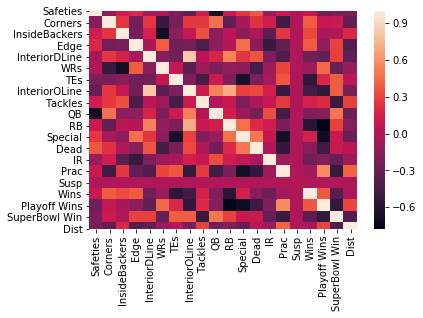

In [6]:
FullComparable('chargers',2012)

The teams most similar to the 2018 Texans (that aren't the Texans or in the future) are the 2017 Broncos (5 Wins), the 2011 Ravens (12 Wins), and the 2007 Steelers (10 Wins). 

# Quickly break down a few examples one-by-one

### 2017 Broncos (5 Wins)

In [320]:
TopTeams = Df.sort_values(by = "Dist")[:1]

NextYear = Df[(Df['Team'] == TopTeams.iloc[0,1])&(Df['Year'] == TopTeams.iloc[0,0]+1)]

Result = NextYear.copy()

Groups2 = Groups.copy()
Groups2.extend(['Dead','IR','Prac','Susp','Wins','Playoff Wins'])
for i in range(0,len(Groups2)):
    Position = Groups2[i]
    NewVal = NextYear[Position].values - TopTeams[Position].values
    Result.iloc[0,i+2] = NewVal
    
Result.iloc[0,0] = '2017 to 2018'
Result

,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win,Dist
148,2017 to 2018,broncos,-0.227726,-0.221059,0.485421,-0.923957,0.176749,-1.961223,-0.427315,0.270024,-0.233475,1.210933,-1.335786,0.568758,0.06,3.84,0.0,0.0,1,0,0,100.0


#### The 2018 Broncos spent considerably less on WRs, Edge Rushers, and RBs, while spending considerably more on their QB, which ultimately only led to a 1-win improvement

In [321]:
TopTeams = Df.sort_values(by = "Dist")[1:2]

NextYear = Df[(Df['Team'] == TopTeams.iloc[0,1])&(Df['Year'] == TopTeams.iloc[0,0]+1)]

Result2 = NextYear.copy()

for i in range(0,len(Groups2)):
    Position = Groups2[i]
    NewVal = NextYear[Position].values - TopTeams[Position].values
    Result2.iloc[0,i+2] = NewVal
    
Result2.iloc[0,0] = str(TopTeams['Year'].values[0]) + " to " +  str(NextYear['Year'].values[0])
Result2

,Year,Team,Safeties,Corners,InsideBackers,Edge,InteriorDLine,WRs,TEs,InteriorOLine,Tackles,QB,RB,Special,Dead,IR,Prac,Susp,Wins,Playoff Wins,SuperBowl Win,Dist
37,2011 to 2012,ravens,0.500458,-0.311136,0.253507,-0.906201,0.684663,-0.264289,-0.602289,-1.629572,0.274676,0.374219,1.181989,-0.764452,6.47,6.74,-0.18,0.0,-2,2,1,3.949323


#### The 2012 Ravens spend much less on Interior Offensive Line and Edge and much more on RB and Interior Defensive Line. The 2012 offseason saw the Ravens lose G Ben Grubbs and DE/NT Cory Redding and drafting future all-pros in Courtney Upshaw and Kelechi Osemele. The Ravens also re-signed RB Ray Rice to a large deal and Interior D-Lineman Haloti Ngata's contract value increased significantly. This ultimately led to fewer regular season wins, but a Super Bowl Win

In [365]:
ChangeFrame = pd.DataFrame()
for j in range(0,11):
    TopTeams = Df.sort_values(by = "Dist")[j:j+1]

    NextYear = Df[(Df['Team'] == TopTeams.iloc[0,1])&(Df['Year'] == TopTeams.iloc[0,0]+1)]

    Result2 = NextYear.copy()

    for i in range(0,len(Groups2)):
        Position = Groups2[i]
        NewVal = NextYear[Position].values - TopTeams[Position].values
        Result2.iloc[0,i+2] = NewVal

    Result2.iloc[0,0] = str(TopTeams['Year'].values[0]) + " to " +  str(NextYear['Year'].values[0])
    ChangeFrame = ChangeFrame.append(Result2)

display(ChangeFrame)
    
X = ChangeFrame.copy()

cor = X.corr()
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)
cor[['Wins','Playoff Wins','SuperBowl Win']]

KeyError: 'Dist'